In [2]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fitting.utils import get_lab_example
from fitting.utils import get_output_dirs

save_outputs = False
results_dir = '/home/mattw/results/behavenet_figs/'

# 1. Plot decoder performance

### load results

In [10]:
# specify decoder directory
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet'}

lab = 'musall'
model_types = ['linear', 'ff']  # keep both
model_class = 'neural-arhmm'  # 'neural-ae' | 'neural-arhmm'
expt_name = 'grid_search'

metrics = []
model_indx = 0
model_counter = 0
for model_type in model_types:

    hparams['n_arhmm_states'] = 8
    get_lab_example(hparams, lab)
    
    _, _, expt_dir = get_output_dirs(
        hparams, model_class=model_class, expt_name=expt_name, model_type=model_type)

    # gather all versions
    def get_dirs(path):
        return next(os.walk(path))[1]
    versions = get_dirs(expt_dir)

    # load csv files with model metrics (saved out from test tube)
    for i, version in enumerate(versions):
        # read metrics csv file
        model_dir = os.path.join(expt_dir, version)
        try:
            metric = pd.read_csv(os.path.join(model_dir, 'metrics.csv'))
            model_counter += 1
        except:
            continue
        # load model info
#         with open(os.path.join(model_dir, 'meta_tags.csv'), mode='r') as f:
#             hp = csv.reader(f)
#             hparams = {rows[0]: rows[1] for rows in hp}
        with open(os.path.join(model_dir, 'meta_tags.pkl'), 'rb') as f:
            hparams = pickle.load(f)
        # append model info to metrics ()
        version_num = version[8:]
        metric['version'] = str('version_%i' % model_indx + version_num)
        for key, val in hparams.items():
            if isinstance(val, (str, int, float)):
                metric[key] = val
        metrics.append(metric)
        
    model_indx += 10000  # assumes no more than 10k model versions in an experiment
# put everything in pandas dataframe
metrics_df = pd.concat(metrics, sort=False)
print('Loaded %i models for analysis' % model_counter)

Loaded 36 models for analysis


### Plot model performance as a function of lags/layers 
### (take best models over learning rate/L2 reg)

In [11]:
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]
best_models_list = []

if 'ff' not in model_types:
    hue = None
else:
    hue = 'n_hid_layers'
    
# take min over val losses
loss_mins = metrics_df.groupby(
    ['n_lags', 'n_hid_layers', 'learning_rate', 'l2_reg', 'version']).min().reset_index()
n_lags = metrics_df.n_lags.unique()
n_lags.sort()
n_hid_layers = metrics_df.n_hid_layers.unique()
n_hid_layers.sort()
for lag in n_lags:
    for layer in n_hid_layers:
        # get all models with this number of lags
        single_hp = loss_mins[(loss_mins.n_lags==lag) & (loss_mins.n_hid_layers==layer)]
        # find best version from these models
        best_version = loss_mins.iloc[single_hp.val_loss.idxmin()].version
        # index back into original data to grab test loss on all batches
        best_models_list.append(data_queried[data_queried.version==best_version])

best_models_df = pd.concat(best_models_list)

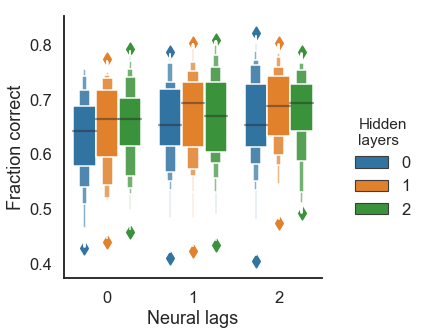

In [14]:
# PLOT
sns.set_style('white')
sns.set_context('talk')

if model_class == 'neural-ae':
    y_axis = 'test_r2' # 'test_loss' | 'test_r2'
    meas_str = 'R2'
    plot_type = 'bar'
elif model_class == 'neural-arhmm':
    y_axis = 'test_fc'
    meas_str = 'FC'
    plot_type = 'boxen'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=best_models_df, ci=None)
if y_axis == 'test_r2':
    splt.ax.set_ylabel('$R^2$')
elif y_axis == 'test_loss':
    splt.ax.set_ylabel('MSE')
elif y_axis == 'test_fc':
    splt.ax.set_ylabel('Fraction correct')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')

if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_%ss_by_trial' % (lab, meas_str))
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

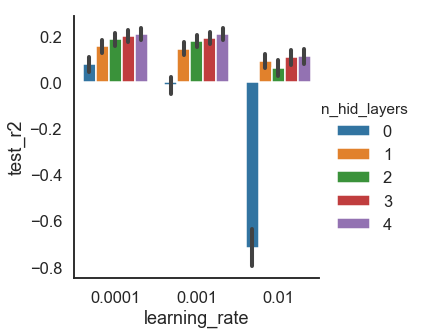

In [14]:
# look at reg vals/learning rate
measure = 'learning_rate'  # 'learning_rate' | 'l2_reg'

if measure == 'learning_rate':
    get_best = 'l2_reg'
else:
    get_best = 'learning_rate'
    
# for each version, only keep rows where test_loss is not nan
data_queried = metrics_df[pd.notna(metrics_df.test_loss)]

# group by get_best, find avgs over all other hyperparams
best_meas = data_queried.groupby([get_best]).mean().reset_index()
# find the best value for get_best
best_meas = best_meas[
    best_meas['test_loss']==best_meas['test_loss'].min()][get_best].values[0]
# subsample data with this value
data_queried = data_queried[data_queried[get_best]==best_meas]

x_axis = measure
y_axis = 'test_r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
hue = 'n_hid_layers'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)

# 2. Make movies

Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_140/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/steinmetz_12_dim_recon_neural.mp4


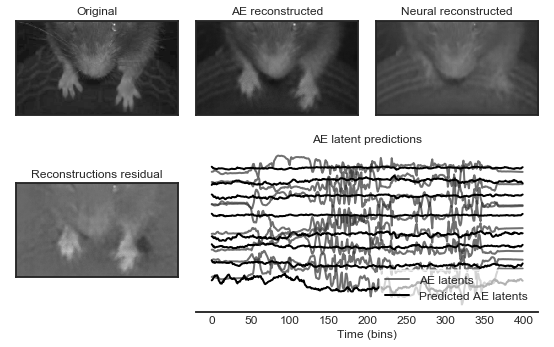

In [19]:
# from analyses.ae.movies import reconstruction
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
from analyses.ae_movies import make_neural_reconstruction_movie

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'test_pt',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best',
    'lib': 'pt'}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:

get_lab_example(hparams, lab)
# fastest way to get test trials
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=['images'], transforms=[None], load_kwargs=[None],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.batch_indxs[0]['test'][4]

if save_outputs:
    save_file = os.path.join(
        results_dir, '%s_%02i_dim_recon_neural' % (lab, hparams['n_ae_latents']))
    make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
else:
    pass   

# 3. Plot AE traces and neural reconstructions

### load data

In [21]:
# find good trials
from fitting.utils import get_data_generator_inputs
from fitting.utils import get_lab_example
from fitting.utils import get_output_dirs
from data.data_generator import ConcatSessionsGenerator

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet'}
# lab = 'steinmetz-face'
get_lab_example(hparams, lab)

# ae data
_, _, ae_model_dir = get_output_dirs(
    hparams, model_class='ae', expt_name='test_pt', model_type='conv')
ae_transforms = None
ae_load_kwargs = {
    'model_dir': ae_model_dir,
    'model_version': 'best'}

# ae predictions data
_, _, ae_pred_dir = get_output_dirs(
    hparams, model_class='neural-ae', expt_name='grid_search', model_type='linear')
ae_pred_transforms = None
ae_pred_load_kwargs = {
    'model_dir': ae_pred_dir,
    'model_version': 'best'}

signals = ['ae', 'ae_predictions']
transforms = [ae_transforms, ae_pred_transforms]
load_kwargs = [ae_load_kwargs, ae_pred_load_kwargs]

# hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals=signals, transforms=transforms, load_kwargs=load_kwargs,
    device='cpu', as_numpy=False, batch_load=False, rng_seed=0)

### plot

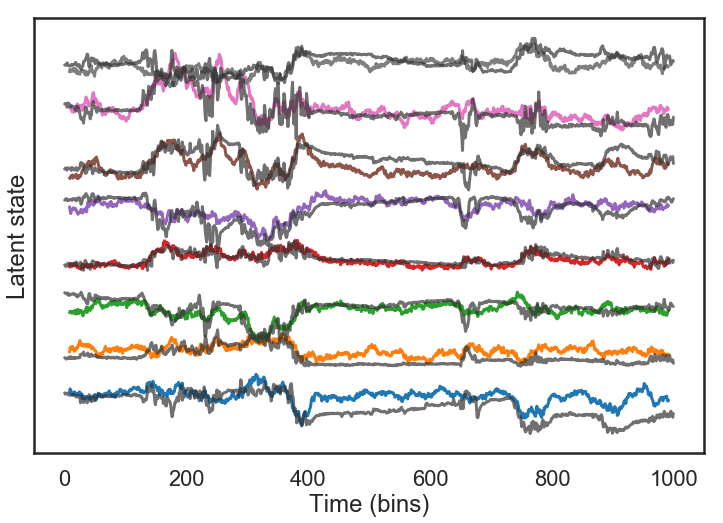

In [22]:
trial = 32 #data_generator.batch_indxs[0]['test'][5]
batch = data_generator.datasets[0][trial]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('white')
sns.set_context('poster')

data_ae = batch['ae'].cpu().detach().numpy()
data_pred = batch['ae_predictions'].cpu().detach().numpy()

means = np.mean(data_ae, axis=0)
std = np.std(data_ae) * 2

data_ae_sc = (data_ae - means) / std
data_pred_sc = (data_pred - means) / std

data_ae_sc = data_ae_sc[:, :8]
data_pred_sc = data_pred_sc[:, :8]

plt.figure(figsize=(12, 8))
plt.plot(
    data_pred_sc + np.arange(data_pred_sc.shape[1]), linewidth=3)
plt.plot(
    data_ae_sc + np.arange(data_ae_sc.shape[1]), color=[0.2, 0.2, 0.2], linewidth=3,
    alpha=0.7)

plt.xlabel('Time (bins)')
plt.ylabel('Latent state')
plt.yticks([])
# plt.yticklabels([0, 2], ['d1', 'd2'])
plt.show()

# 1A. Calculate $R^2$/FC over entire test data

### get best models from before

In [16]:
def get_test_r2(hparams, model_version):
    
    from sklearn.metrics import r2_score
    from fitting.utils import get_best_model_and_data
    from behavenet.models import Decoder
    
    model, data_generator = get_best_model_and_data(
        hparams, Decoder, load_data=True, version=model_version)

    num_test_batches = len(data_generator.batch_indxs[0]['test'])
    max_lags = hparams['n_max_lags']
    latents_ae = []
    latents_pred = []
    data_generator.reset_iterators('test')
    for i in range(num_test_batches):
        batch, _ = data_generator.next_batch('test')

        # get true latents
        curr_latents_ae = batch['ae'][0].cpu().detach().numpy()
        
        # get predicted latents
        curr_latents_pred = model(batch['neural'][0]).cpu().detach().numpy()

        latents_ae.append(curr_latents_ae[max_lags:-max_lags])
        latents_pred.append(curr_latents_pred[max_lags:-max_lags])

    r2 = r2_score(
        np.concatenate(latents_ae, axis=0),
        np.concatenate(latents_pred, axis=0),
        multioutput='variance_weighted')
    
    return model.hparams, r2

In [17]:
versions = best_models_df.version.unique()

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'n_max_lags': 8}

# labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']

# for lab in labs:

get_lab_example(hparams, lab)

hparams['model_class'] = 'neural-ae'
all_test_r2s = []
for version in versions:
    # get model version/model type
    if len(version) > 13:
        model_version = int(version[13:])
        hparams['model_type'] = 'ff'
    else:
        model_version = int(version[8:])
        hparams['model_type'] = 'linear'
        
    hparams_, r2 = get_test_r2(hparams, model_version)
    all_test_r2s.append(pd.DataFrame({
        'n_hid_layers': hparams_['n_hid_layers'],
        'n_lags': hparams_['n_lags'],
        'r2': r2}, index=[0]))
#     print('version: %i; type: %s' % (model_version, model_type))
all_test_r2s_df = pd.concat(all_test_r2s)

Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/linear/test_tube_data/grid_search/version_38/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_36/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_29/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_84/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_117/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe/mouse-01/session-01/neural-ae/12_latents/linear/test_tube_data/grid_search/ve

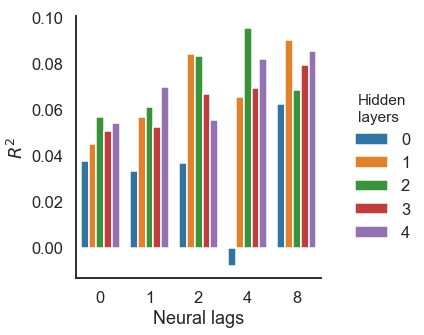

In [18]:
# PLOT
sns.set_style('white')
sns.set_context('talk')

y_axis = 'r2' # 'test_loss' | 'test_r2'
plot_type = 'bar'
x_axis = 'n_lags'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=all_test_r2s_df)
splt.ax.set_ylabel('$R^2$')
splt.ax.set_xlabel('Neural lags')
if hue is not None:
    splt._legend.set_title('Hidden\nlayers')

if save_outputs:
    save_file = os.path.join(results_dir, '%s_decoder_R2s_across_trials' % lab)
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

# 4. Plot $R^2$/FC across all datasets

In [20]:
from fitting.utils import get_subdirs
from fitting.utils import get_best_model_version

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'model_class': 'neural-arhmm',  # 'neural-ae' | 'neural-arhmm'
}

labs = ['musall'] #['steinmetz', 'steinmetz-face', 'musall', 'datta']
model_types = ['ff']

if hparams['model_class'] == 'neural-ae':
    val_meas = 'val_r2'
    test_meas = 'test_r2'
    train_meas = 'tr_r2'
else:
    val_meas = 'val_fc'
    test_meas = 'test_fc'
    train_meas = 'tr_fc'
    
metrics_df = []
for lab in labs:
    hparams['n_arhmm_states'] = 8
    get_lab_example(hparams, lab)
    for model_type in model_types:
        hparams['model_type'] = model_type
        
        # get measures from best decoder
        hparams['experiment_name'] = 'grid_search'
        _, _, expt_dir = get_output_dirs(hparams)
        model_version = get_best_model_version(expt_dir)[0]
        metric_file = os.path.join(expt_dir, model_version, 'metrics.csv')
        metrics = pd.read_csv(metric_file)
        for i, row in metrics.iterrows():
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row[val_meas],
                'dtype': 'val',
                'model_type': model_type,
                'data': lab,
                'shuffled': False
            }, index=[0]))
            metrics_df.append(pd.DataFrame({
                'epoch': row['epoch'],
                'loss': row[train_meas],
                'dtype': 'train',
                'model_type': model_type,
                'data': lab,
                'shuffled': False
            }, index=[0]))
            if 'test_loss' in row:
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[test_meas],
                    'dtype': 'test',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': False
                }, index=[0]))
                
        # get measures from shuffled data
        hparams['experiment_name'] = 'shuffle'
        _, _, expt_dir = get_output_dirs(hparams)
        versions = get_subdirs(expt_dir)
        for version in versions:
            metric_file = os.path.join(expt_dir, version, 'metrics.csv')
            metrics = pd.read_csv(metric_file)
            for i, row in metrics.iterrows():
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[val_meas],
                    'dtype': 'val',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': True
                }, index=[0]))
                metrics_df.append(pd.DataFrame({
                    'epoch': row['epoch'],
                    'loss': row[train_meas],
                    'dtype': 'train',
                    'model_type': model_type,
                    'data': lab,
                    'shuffled': True
                }, index=[0]))
                if 'test_loss' in row:
                    metrics_df.append(pd.DataFrame({
                        'epoch': row['epoch'],
                        'loss': row[test_meas],
                        'dtype': 'test',
                        'model_type': model_type,
                        'data': lab,
                        'shuffled': True
                    }, index=[0]))
        
metrics_df = pd.concat(metrics_df)

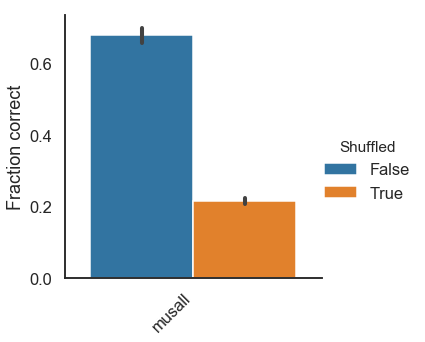

In [21]:
sns.set_style('white')
sns.set_context('talk')

data_queried = metrics_df[metrics_df.dtype=='test']
y_axis = 'loss'
plot_type = 'bar'  # 'bar' | 'box' | 'boxen'
hue = 'shuffled'
x_axis = 'data'

splt = sns.catplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)

plt.ylabel('Fraction correct')
plt.xlabel('')
splt.ax.set_xticklabels(data_queried.data.unique(), rotation=45, ha='right')
splt._legend.set_title('Shuffled')

save_file = os.path.join(results_dir, 'all_decoder_discrete_fcs')
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')
    
plt.show()

# 5. Make movies for n best/worst trials

Trial 42: 0.3685413749254869
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_294/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/top_n_movies/steinmetz-face_12_dim_trial-042_r2-0.37.mp4
Trial 82: -48.76231962450803
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_294/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/top_n_movies/steinmetz-face_12_dim_trial-082_r2--48.76.mp4
Trial 32: 0.20947314947757206
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_294/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/top_n_movies/steinmetz-face_12_dim_trial-032_r2-0.21.mp4
Trial 102: -2.276736224520228
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/ae/conv/12_latents/test_tube_data/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_294/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000
processing frame 100
processing frame 200
processing frame 300
saving video
video saved to /home/mattw/results/behavenet_figs/top_n_movies/steinmetz-face_12_dim_trial-102_r2--2.28.mp4


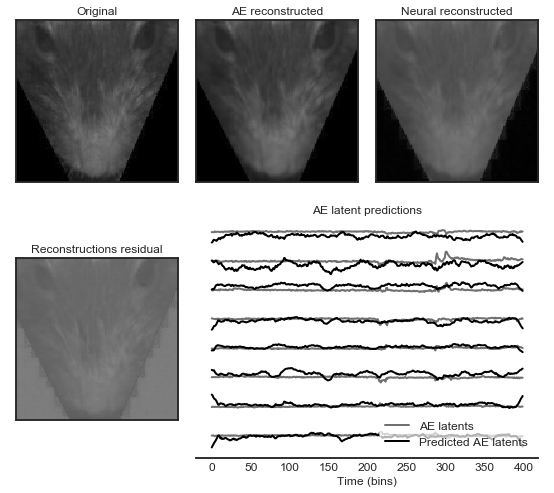

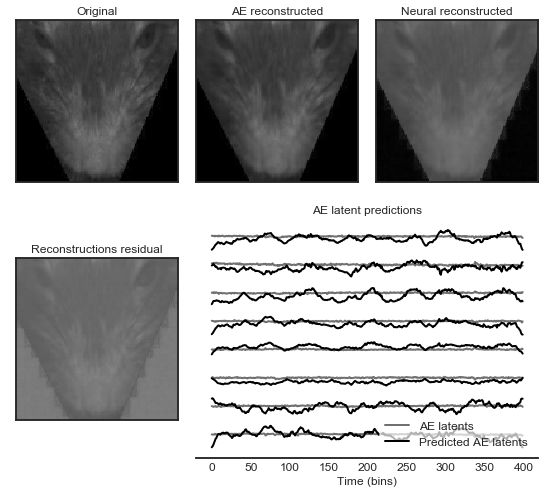

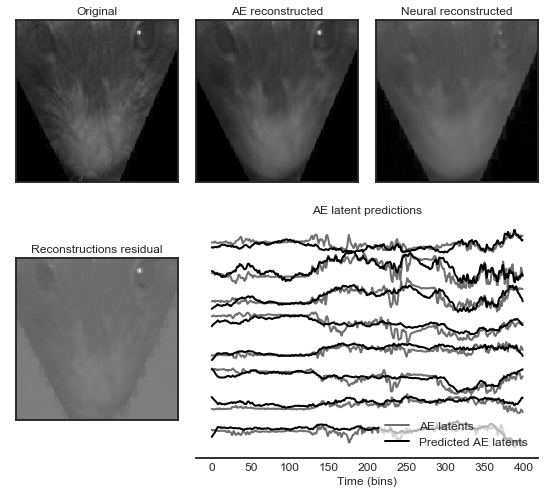

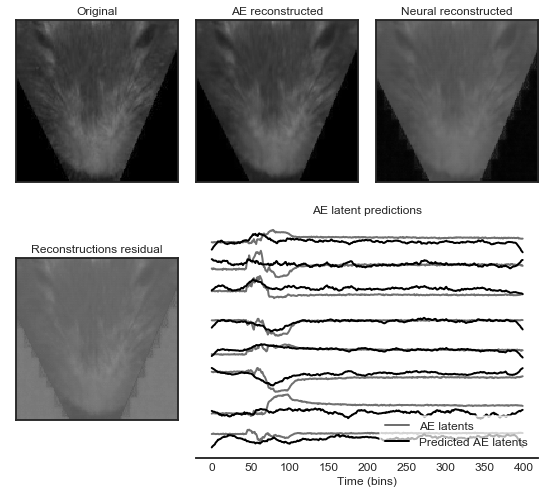

In [10]:
import copy
from fitting.utils import get_lab_example
from fitting.utils import get_best_model_version
from data.data_generator import ConcatSessionsGenerator
from analyses.ae_movies import make_neural_reconstruction_movie

n_trials = 2

hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'ae_experiment_name': 'test_pt',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': 'best',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': 'best',
    'lib': 'pt'}

# lab = 'musall'
get_lab_example(hparams, lab)

# load fitting metrics
hparams_ = copy.copy(hparams)
hparams_['model_class'] = hparams['decoder_model_class']
hparams_['experiment_name'] = hparams['decoder_experiment_name']
hparams_['model_type'] = hparams['decoder_model_type']
_, _, expt_dir = get_output_dirs(hparams_)
best_version = get_best_model_version(expt_dir)[0]
version_dir = os.path.join(expt_dir, best_version)
metrics_file = os.path.join(version_dir, 'metrics.csv')
metrics = pd.read_csv(metrics_file)
metrics = metrics[pd.notna(metrics.test_loss)]

# find r2s of all trials
r2s = metrics['test_r2'].sort_values().reset_index()

for n in range(n_trials):
    # get good trial
    index = r2s.iloc[-1-n]['index']
    trial = int(metrics[metrics.index==index].iloc[0]['trial'])
    r2 = metrics[metrics.index==index].iloc[0]['test_r2']
    print('Trial {}: {}'.format(trial, r2))
    if save_outputs:
        save_file = os.path.join(
            results_dir, 'top_n_movies', '%s_%02i_dim_trial-%03i_r2-%1.2f' % 
            (lab, hparams['n_ae_latents'], trial, r2))
        make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
    else:
        pass   

    # get bad trials
    index = r2s.iloc[n]['index']
    trial = int(metrics[metrics.index==index].iloc[0]['trial'])
    r2 = metrics[metrics.index==index].iloc[0]['test_r2']
    print('Trial {}: {}'.format(trial, r2))
    if save_outputs:
        save_file = os.path.join(
            results_dir, 'top_n_movies', '%s_%02i_dim_trial-%03i_r2-%1.2f' % 
            (lab, hparams['n_ae_latents'], trial, r2))
        make_neural_reconstruction_movie(hparams, save_file=save_file, trial=trial)
    else:
        pass